Libraries

In [3]:
import numpy as np
# from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

Solving Classical LK 2D system

In [5]:
def LV(x,a,b,c,d):    
    xdot = np.array([a*x[0] - b*x[0]*x[1], d*x[0]*x[1] - c*x[1]])
    return xdot

In [6]:
def RK4(f, x0, t0, tf, dt):
    
    t = np.arange(t0, tf, dt)
    nt = t.size
    
    nx = x0.size
    x = np.zeros((nx,nt))
    
    x[:,0] = x0
    
    for k in range(nt-1):
        k1 = dt*f(t[k], x[:,k])
        k2 = dt*f(t[k] + dt/2, x[:,k] + k1/2)
        k3 = dt*f(t[k] + dt/2, x[:,k] + k2/2)
        k4 = dt*f(t[k] + dt, x[:,k] + k3)
        
        dx=(k1 + 2*k2 + 2*k3 +k4)/6
        x[:,k+1] = x[:,k] + dx;  
    
    return x, t

In [7]:
# Defining the problem
a = 1
b = 1
c = 1
d = 1

f= lambda t,x : LV(x,a,b,c,d)         # lambda is an anonymous function which can take may inputs but returns one output. Same case is with MATLAB denoted by @.
x0 = np.array([0.5,1])                 # initial condition    

# Solving the problem
t0 = 0                                # time unit is second
tf = 15
num_points = 1000
dt = (tf - t0) / (num_points - 1)
x, t = RK4(f, x0, t0, tf, dt)

In [ ]:
# Plot the solution
plt.plot(t, x[0], label='Prey')
plt.plot(t, x[1], label='Predator')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Lotka-Volterra Predator-Prey Model')
plt.legend()
plt.grid(True)
plt.show()

Generating Noisy Observational Data 

In [28]:
# Randomly sample 100 values from the array of discretized times t
random_indices = np.random.choice(len(t), size=30, replace=False)

x_obs = [x[0][ind] for ind in random_indices]
y_obs = [x[1][ind] for ind in random_indices]

# Generate Gaussian noise for x_obs and y_obs
noise_x = 0.02 * np.random.randn(len(x_obs))
noise_y = 0.02 * np.random.randn(len(y_obs))

# Add the noise to the observed values
x_obs_noise = [x_obs[ind] + noise_x[ind] for ind in range(len(x_obs))]
y_obs_noise = [y_obs[ind] + noise_y[ind] for ind in range(len(y_obs))]

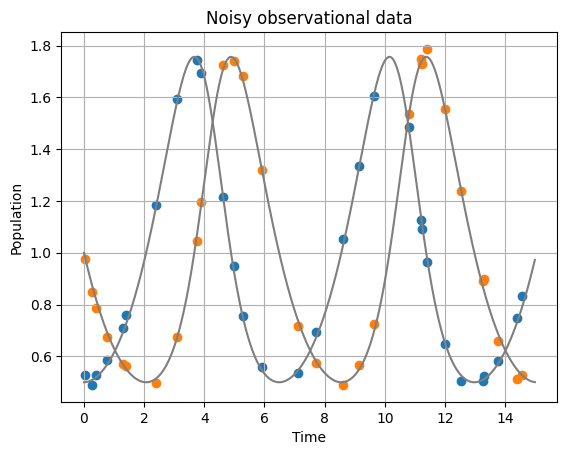

In [29]:
plt.figure()
plt.title("Noisy observational data")
plt.scatter([t[ind] for ind in random_indices], x_obs_noise)
plt.scatter([t[ind] for ind in random_indices], y_obs_noise)
plt.plot(t, x[0], label='Exact Prey', color="tab:grey")
plt.plot(t, x[1], label='Exact Predator', color="tab:grey")
plt.xlabel('Time')
plt.ylabel('Population')
plt.grid(True)
plt.show()